## User churn prediction using Machine Learning algorithm
### *Model implemented: Logistic Regression, Random Forest, Gradient Boosted Tree, Naive Bayes
### *Model performance evaluated by AUC score

### Load data

In [1]:
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark import SparkContext
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')# the last two lines have to be added for spark.read.csv to run
spark = SparkSession(sc)

In [2]:
df = spark.read.csv('../data/df_model_final_2.csv',header=True,inferSchema=True).cache()
df.show(5)

+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------+----------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+
|      uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|device_type|days_from_last_P|days_from_last_D|days_from_last_S|play_time_last_1|play_time_last_3|play_time_last_7|play_time_last_14|play_time_last_30|
+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------

In [3]:
df

DataFrame[uid: int, label: int, freq_P_last_1: int, freq_P_last_3: int, freq_P_last_7: int, freq_P_last_14: int, freq_P_last_30: int, freq_D_last_1: int, freq_D_last_3: int, freq_D_last_7: int, freq_D_last_14: int, freq_D_last_30: int, freq_S_last_1: int, freq_S_last_3: int, freq_S_last_7: int, freq_S_last_14: int, freq_S_last_30: int, device_type: int, days_from_last_P: int, days_from_last_D: int, days_from_last_S: int, play_time_last_1: int, play_time_last_3: int, play_time_last_7: int, play_time_last_14: int, play_time_last_30: int]

### Prepare training data

In [8]:
selected_features = df.columns
selected_features.remove('uid')
selected_features.remove('label')
selected_features.remove('device_type')
selected_features

['freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30',
 'days_from_last_P',
 'days_from_last_D',
 'days_from_last_S',
 'play_time_last_1',
 'play_time_last_3',
 'play_time_last_7',
 'play_time_last_14',
 'play_time_last_30']

In [9]:
# training data
assembler = VectorAssembler(
    inputCols=selected_features,
    outputCol="features")
data = assembler.transform(df)

# train test split
(train, test) = data.randomSplit([0.7, 0.3], seed=1)

### Fit logistic regression

In [67]:
ml = LogisticRegression(maxIter=100, regParam=0.0001, elasticNetParam=0.8)
model_log = ml.fit(train)

In [97]:
import pandas as pd
Log_coeff=model_log.coefficientMatrix
Log_coeff
print(Log_coeff)

DenseMatrix([[-2.47548255e-02, -8.34901797e-03, -1.95605553e-03,
              -1.09233441e-03,  1.86974440e-05,  1.75092213e-03,
               3.28641450e-03,  4.98462603e-03, -5.78716554e-03,
              -5.96034723e-04,  5.34142297e-02, -4.27851698e-02,
              -1.48022026e-02, -6.57962191e-03, -1.92998923e-03,
               1.38952962e-01, -9.42379798e-03, -1.27316605e-02,
               1.57312773e-09,  1.57312773e-09,  1.57312773e-09,
               1.57312773e-09,  1.57312773e-09]])


In [ ]:
# looks like the top 5 most import features are: 
#'days_from_last_play','freq_S_last_1','freq_S_last_3','freq_P_last_1','freq_S_last_7'

In [71]:
model_log.interceptVector

DenseVector([-2.017])

### Predict and Evaluate performance

In [59]:
#### predict and evaluate performance

# Predict train data
predictions_train = model_log.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model_log.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()


+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.57207562137635...|       0.0|    0|(23,[2,3,4,9,15,1...|
|[0.43131617766252...|       1.0|    1|(23,[3,4,13,14,15...|
|[0.97907060559880...|       0.0|    0|[19.0,127.0,307.0...|
|[0.70252621129402...|       0.0|    0|(23,[1,2,3,4,7,8,...|
|[0.81330559200127...|       0.0|    0|(23,[1,2,3,4,14,1...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.21023472004105...|       1.0|    1|(23,[4,15,18,19,2...|
|[0.63645071173969...|       0.0|    1|(23,[2,3,4,12,13,...|
|[0.97215895943577...|       0.0|    0|(23,[0,1,2,3,4,9,...|
|[0.89163004451296...|       0.0|    0|(23,[0,1,2,3,4,13...|

### Evaluate performance

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    

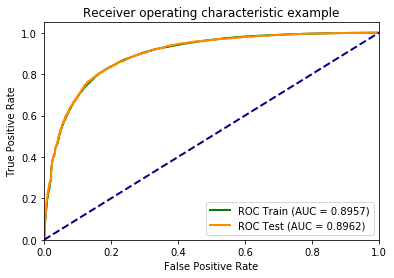

In [60]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

### Random forest 

In [31]:
ml = RandomForestClassifier(labelCol="label", featuresCol="features"
                            ,numTrees=100#50
                            ,featureSubsetStrategy="auto"
                            ,impurity='gini'
                            ,maxDepth=10#20 overfited the trainig set
                            ,minInstancesPerNode=10
                            ,maxBins=16
                            )
model_rf = ml.fit(train)

In [32]:
#### predict and evaluate performance

# Predict train data
predictions_train = model_rf.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model_rf.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.61003367222859...|       0.0|    0|(23,[2,3,4,9,15,1...|
|[0.47056031098064...|       1.0|    1|(23,[3,4,13,14,15...|
|[0.99071177501893...|       0.0|    0|[19.0,127.0,307.0...|
|[0.78198288864089...|       0.0|    0|(23,[1,2,3,4,7,8,...|
|[0.81938676233547...|       0.0|    0|(23,[1,2,3,4,14,1...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.07457511702904...|       1.0|    1|(23,[4,15,18,19,2...|
|[0.72641288235481...|       0.0|    1|(23,[2,3,4,12,13,...|
|[0.93093773714250...|       0.0|    0|(23,[0,1,2,3,4,9,...|
|[0.97475476240300...|       0.0|    0|(23,[0,1,2,3,4,13...|

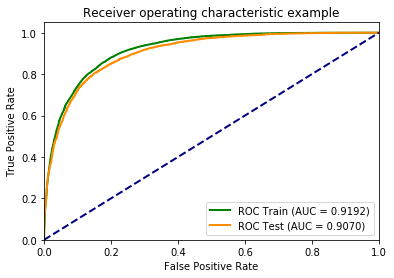

In [33]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

### Gradient Boosted Tree

In [43]:
gbt=GBTClassifier(labelCol='label',featuresCol='features',maxIter=20,maxDepth=5,minInstancesPerNode=20)
model_gbt=gbt.fit(train)

In [44]:
#### predict and evaluate performance

# Predict train data
predictions_train = model_gbt.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model_gbt.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.59039660196104...|       0.0|    0|(23,[2,3,4,9,15,1...|
|[0.41515678192942...|       1.0|    1|(23,[3,4,13,14,15...|
|[0.94879836775400...|       0.0|    0|[19.0,127.0,307.0...|
|[0.79435616769659...|       0.0|    0|(23,[1,2,3,4,7,8,...|
|[0.85959510338518...|       0.0|    0|(23,[1,2,3,4,14,1...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.14755417579709...|       1.0|    1|(23,[4,15,18,19,2...|
|[0.68707308908212...|       0.0|    1|(23,[2,3,4,12,13,...|
|[0.93708466849631...|       0.0|    0|(23,[0,1,2,3,4,9,...|
|[0.94302594262536...|       0.0|    0|(23,[0,1,2,3,4,13...|

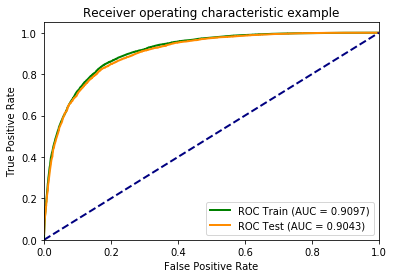

In [45]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

### Naive Bayes

In [50]:
from pyspark.ml.classification import NaiveBayes
nb=NaiveBayes(smoothing=4,modelType='multinomial')
model_nb=nb.fit(train)


predictions=model_nb.transform(test)
predictions.show(5)
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()

# Predict test data
predictions_test = model_rf.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()
#evaluator=MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
#accuracy=evaluator.evaluate(predictions)
#print('Test accuracy=', accuracy)

+-------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------+----------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|    uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|device_type|days_from_last_P|days_from_last_D|days_from_last_S|play_time_last_1|play_time_last_3|play_time_last_7|play_time_last_14|play_time_last_30|            features|       rawPrediction|         probability|prediction|
+-------+-----+-------------+-------------+-------------+--------------+--------------+-

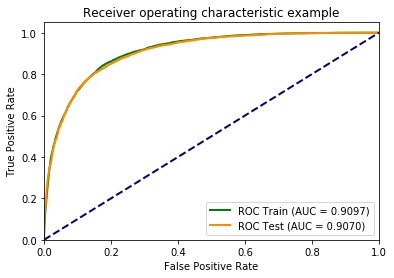

In [51]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)